In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook
sns.set()

In [10]:
# set this to your local analysis ID
ANALYSIS_ID = '0068b6737de34daab4c84693960652c0'

The SRD data vector is `[src-src, src-lens, lens-lens]` where
all `src` bin combinations are kept, only the `src-lens` combinations
below are kept, and only the diagonal `lens-lens` combinations are kept.

In [11]:
n_src = 5
n_lens = 5
lens_src_pairs = [(0, 2), (0, 3), (0, 4), (1, 3), (1, 4), (2, 4), (3, 4)]

Here we read in the copy of the fiducial SRD computations.

In [12]:
datav = pd.read_csv('srd_data/Y1_3x2pt_clusterN_clusterWL_fid.csv')['val'].array.to_numpy()

In [13]:
assert len(datav) == (5*(5+1)//2 + 7 + 5)*20

# Plot the Redshift Distributions

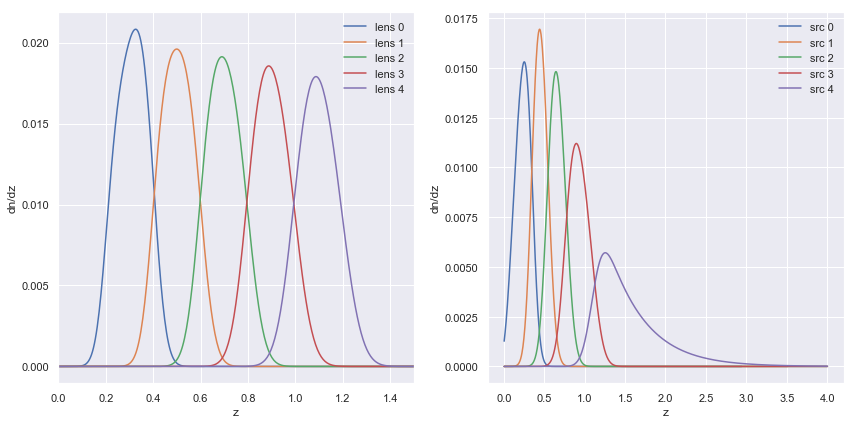

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax = axs[0]
for i in range(n_lens):
    df = pd.read_csv('./data_gen/lens%d_dndz.csv' % i)
    df['dndz'] /= np.sum(df['dndz'])
    ax.plot(df['z'], df['dndz'], label='lens %d' % i)

ax.set_xlabel('z')
ax.set_ylabel('dn/dz')
ax.legend(loc=1, frameon=False)
ax.set_xlim(0.0, 1.5)

ax = axs[1]
for i in range(n_src):
    df = pd.read_csv('./data_gen/src%d_dndz.csv' % i)
    df['dndz'] /= np.sum(df['dndz'])
    ax.plot(df['z'], df['dndz'], label='src %d' % i)

ax.set_xlabel('z')
ax.set_ylabel('dn/dz')
ax.legend(loc=1, frameon=False)

plt.tight_layout()

# Compare Firecrown to the SRD for Cosmic Shear

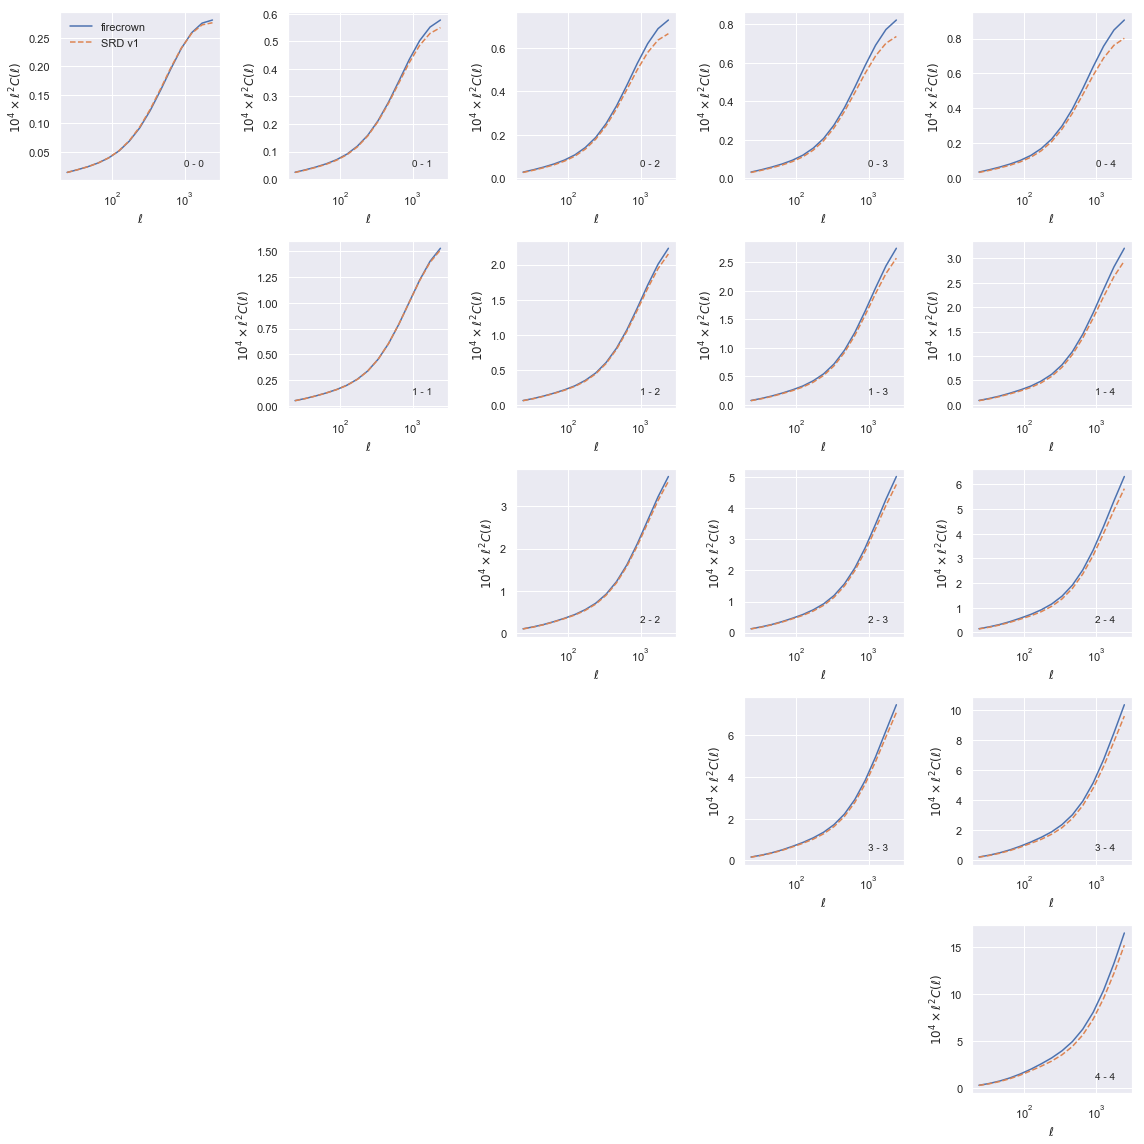

In [15]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(16, 16))

loc = 0
for i in range(n_src):
    for j in range(n_src):
        # skip extra plots
        if i > j:
            axs[i, j].axis('off')
            continue
        
        # read in the SRD values
        cl_data = pd.read_csv('output_%s/two_point/cl_src%d_src%d.csv' % (
            ANALYSIS_ID, i, j))
        ax = axs[i, j]
        
        # this is a factor of 10^4 x ell^2 to take out the dynamic range
        fac = 1e4 * cl_data['ell_or_theta'].array.to_numpy()**2
        
        # firecrown
        ax.semilogx(
            cl_data['ell_or_theta'], 
            fac * cl_data['predicted_statistic'].array.to_numpy(), 
            label='firecrown')
        
        # grab the right section of the SRD model
        assert np.sum(datav[loc:loc+20] > 0) == len(fac)

        vals = datav[loc:loc + len(fac)]
        ax.semilogx(
            cl_data['ell_or_theta'], 
            fac * vals, linestyle='dashed',
            label='SRD v1')
        loc += 20
        
        if i == 0 and j == 0:
            ax.legend(loc=2, frameon=False)
        
        ax.text(
            0.9, 0.1, '%d - %d' % (i, j), 
            horizontalalignment='right',
            verticalalignment='center', 
            transform=ax.transAxes)

        ax.set_xlabel('$\ell$')
        ax.set_ylabel(r'$10^{4}\times\ell^{2}C(\ell)$')
            
plt.tight_layout()

assert loc == (5*(5+1)//2*20)

# Compare Firecrown to SRD for GG Lensing

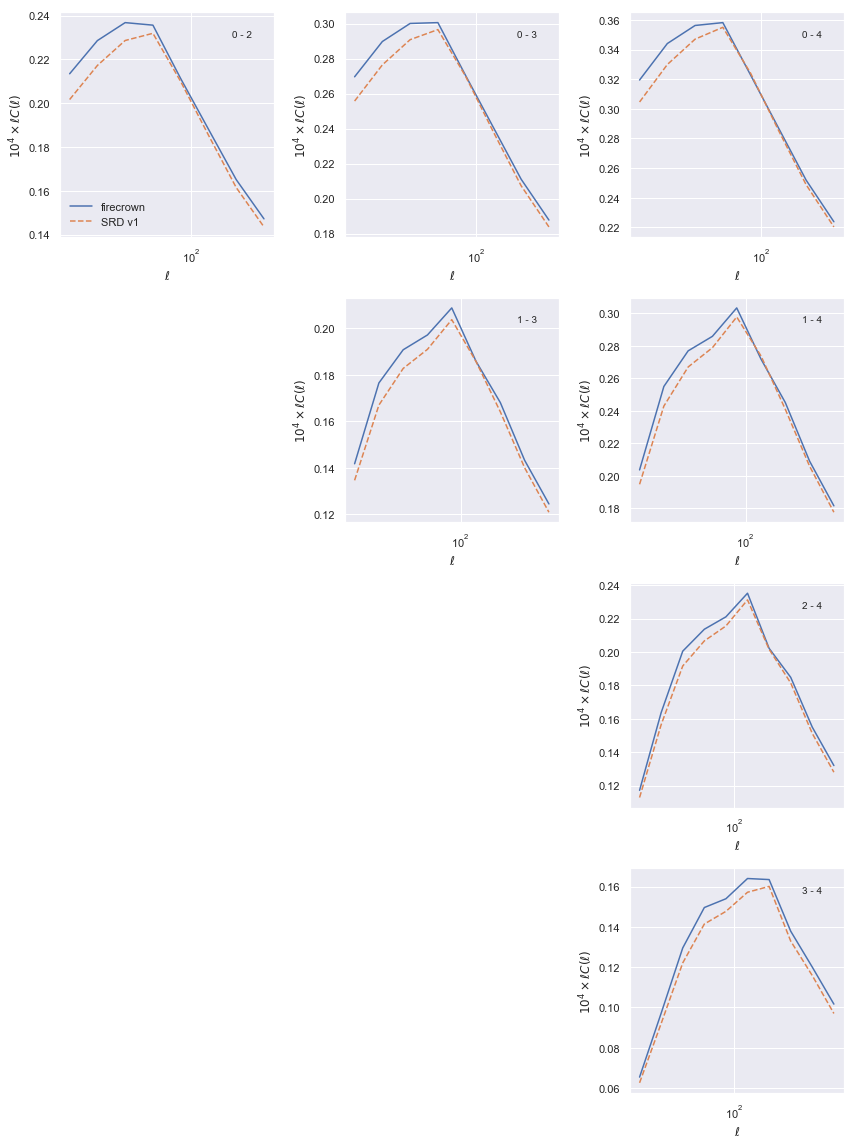

In [16]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 16))

# get loc excluding cosmic shear
loc = (5*(5+1)//2*20)

axk = []
for i in range(4):
    for j in range(3):
        ax = axs[i, j]
        if i == 0:
            axk.append(ax)
        elif i == 1 and j in [1, 2]:
            axk.append(ax)
        elif i in [2, 3] and j == 2:
            axk.append(ax)
        else:
            ax.axis('off')

for (lensi, srci), ax in zip(lens_src_pairs, axk):
    # read in the SRD values
    cl_data = pd.read_csv('output_%s/two_point/cl_src%d_lens%d.csv' % (
        ANALYSIS_ID, srci, lensi))
        
    # this is a factor of 10^4 x ell to take out the dynamic range
    fac = 1e4 * cl_data['ell_or_theta'].array.to_numpy()
        
    # firecrown
    ax.semilogx(
        cl_data['ell_or_theta'], 
        fac * cl_data['predicted_statistic'].array.to_numpy(),
        label='firecrown')
        
    # grab the right section of the SRD model
    assert np.sum(datav[loc:loc+20] > 0) == len(fac)
    
    vals = datav[loc:loc + len(fac)]
    ax.semilogx(
        cl_data['ell_or_theta'], 
        fac * vals, linestyle='dashed',
        label='SRD v1')
    
    loc += 20
        
    if lensi == 0 and srci == 2:
        ax.legend(loc=3, frameon=False)
        
    ax.text(
        0.9, 0.9, '%d - %d' % (lensi, srci), 
        horizontalalignment='right',
        verticalalignment='center', 
        transform=ax.transAxes)

    ax.set_xlabel('$\ell$')
    ax.set_ylabel(r'$10^{4}\times\ell C(\ell)$')
            
plt.tight_layout()

assert loc == (5*(5+1)//2*20) + 7*20

# Compare Firecrown to SRD for Clustering

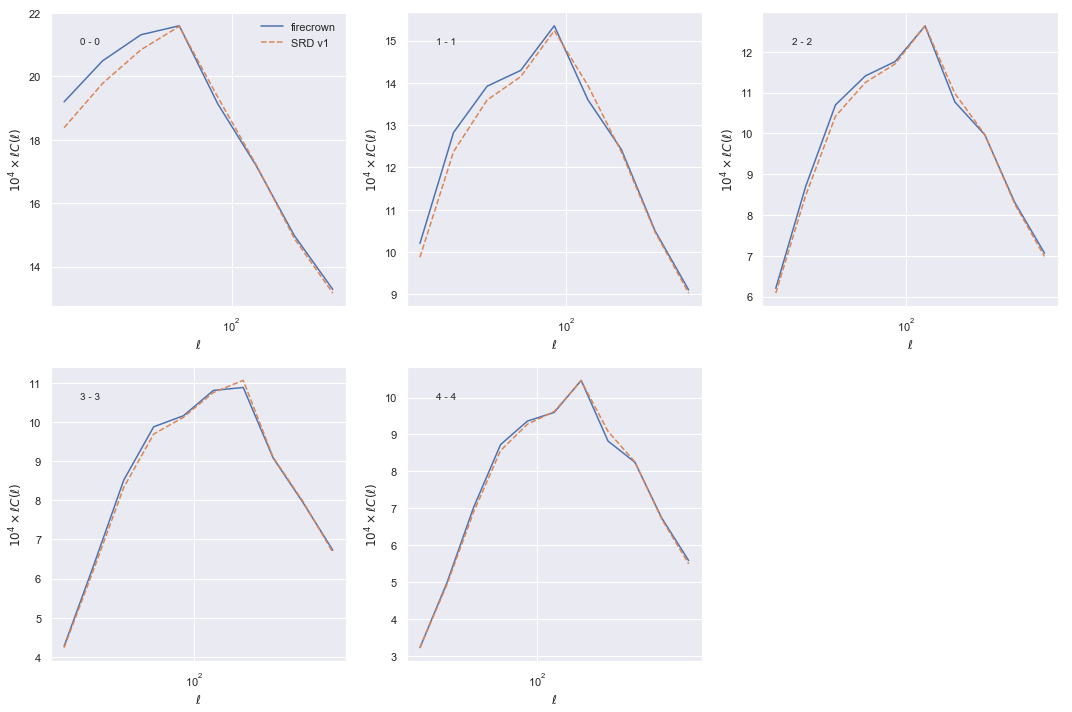

In [17]:
# get loc excluding cosmic shear and gg lensing
loc = (5*(5+1)//2*20) + 7*20

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

axs = axs.ravel()
axs[-1].axis('off')
for i in range(n_lens):
    ax = axs[i]

    # read in the SRD values
    cl_data = pd.read_csv('output_%s/two_point/cl_lens%d_lens%d.csv' % (
        ANALYSIS_ID, i, i))
        
    # this is a factor of 10^4 x ell to take out the dynamic range
    ell = cl_data['ell_or_theta'].array.to_numpy()
    fac = 1e4 * ell
    
    dvals = datav[loc:loc + 20]
    vals = cl_data['predicted_statistic'].array.to_numpy()
    
    assert np.sum(dvals > 0) == len(fac)

    msk = dvals > 0
    dvals = dvals[msk]
    if np.sum(msk) > len(ell):
        msk = msk[:len(ell)]
        dvals = dvals[:len(ell)]
    else:
        ell = ell[:len(dvals)]
        fac = fac[:len(dvals)]
        vals = vals[:len(dvals)]
    
    # firecrown
    ax.semilogx(
        ell, 
        (fac * vals),
        label='firecrown')
        
    # grab the right section of the SRD model
    ax.semilogx(
        ell, 
        (fac * dvals), 
        linestyle='dashed',
        label='SRD v1')
    
    loc += 20
        
    if i == 0:
        ax.legend(loc=1, frameon=False)
        
    ax.text(
        0.1, 0.9, '%d - %d' % (i, i), 
        horizontalalignment='left',
        verticalalignment='center', 
        transform=ax.transAxes)

    ax.set_xlabel('$\ell$')
    ax.set_ylabel(r'$10^{4}\times\ell C(\ell)$')
            
plt.tight_layout()

assert loc == datav.shape[0]